# Baseline Sentiment Classification Models

This notebook implements baseline machine learning models for multimodal sentiment analysis using concatenated features from EEG, GSR, facial action units, and self-report data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from sklearn.metrics import cohen_kappa_score
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Baseline modeling libraries loaded successfully!")

Baseline modeling libraries loaded successfully!


## Load Preprocessed Data

Loading the multimodal features and sentiment labels created during preprocessing.

In [4]:
# Load preprocessed data
try:
    # Load features and labels
    features_df = pd.read_csv('../data/multimodal_features.csv')
    labels_df = pd.read_csv('../data/sentiment_labels.csv')
    
    print("Data loaded successfully!")
    print(f"Features shape: {features_df.shape}")
    print(f"Labels shape: {labels_df.shape}")
    
    # Display feature distribution
    print(f"\nFeature columns: {list(features_df.columns)}")
    
    # Extract labels - the sentiment column is '0'
    y = labels_df['0'].astype(int)  # Convert to integer labels
    
    # Display label distribution
    print(f"\nSentiment label distribution:")
    print(y.value_counts().sort_index())
    
    # Map labels to meaningful names
    label_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    print(f"\nLabel mapping: {label_mapping}")
    
    # Extract features (remove participant_id if it exists)
    X = features_df.drop(['participant_id'], axis=1, errors='ignore')
    
    print(f"\nFinal feature matrix shape: {X.shape}")
    print(f"Final label vector shape: {y.shape}")
    
    # Display basic statistics
    print(f"\nClass distribution percentages:")
    class_counts = y.value_counts().sort_index()
    for label, count in class_counts.items():
        percentage = (count / len(y)) * 100
        print(f"{label_mapping[label]}: {count} samples ({percentage:.1f}%)")
    
except Exception as e:
    print(f"Error loading data: {e}")
    import traceback
    traceback.print_exc()
    print("Please ensure preprocessing has been completed and data files exist.")

Data loaded successfully!
Features shape: (38, 60)
Labels shape: (38, 2)

Feature columns: ['participant_id', 'delta_mean', 'delta_std', 'delta_max', 'delta_min', 'theta_mean', 'theta_std', 'theta_max', 'theta_min', 'alpha_mean', 'alpha_std', 'alpha_max', 'alpha_min', 'beta_mean', 'beta_std', 'beta_max', 'beta_min', 'gamma_mean', 'gamma_std', 'gamma_max', 'gamma_min', 'frontal_asymmetry', 'GSR Resistance CAL_mean', 'GSR Resistance CAL_std', 'GSR Resistance CAL_max', 'GSR Resistance CAL_min', 'GSR Resistance CAL_range', 'GSR Resistance CAL_peaks', 'GSR Resistance CAL_peak_rate', 'GSR Resistance CAL_recovery_slope', 'GSR Conductance CAL_mean', 'GSR Conductance CAL_std', 'GSR Conductance CAL_max', 'GSR Conductance CAL_min', 'GSR Conductance CAL_range', 'GSR Conductance CAL_peaks', 'GSR Conductance CAL_peak_rate', 'GSR Conductance CAL_recovery_slope', 'GSR RAW_mean', 'GSR RAW_std', 'GSR RAW_max', 'GSR RAW_min', 'GSR RAW_range', 'GSR RAW_peaks', 'GSR RAW_peak_rate', 'GSR RAW_recovery_slope'

In [3]:
# Check the structure of the labels file
print("Checking labels file structure:")
print("Labels columns:", labels_df.columns.tolist())
print("Labels head:")
print(labels_df.head())
print("Labels info:")
print(labels_df.info())

Checking labels file structure:
Labels columns: ['Unnamed: 0', '0']
Labels head:
   Unnamed: 0    0
0           0  1.0
1           1  2.0
2           2  0.0
3           3  0.0
4           4  0.0
Labels info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  38 non-null     int64  
 1   0           38 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 740.0 bytes
None


## Data Preprocessing for Modeling

Preparing the data for machine learning by splitting into train/test sets and standardizing features.

In [6]:
# Clean data before modeling - handle infinite and NaN values
print("Cleaning data...")
print(f"Original data shape: {X.shape}")

# Check for infinite and NaN values
inf_counts = np.isinf(X).sum()
nan_counts = np.isnan(X).sum()

print(f"Infinite values found: {inf_counts.sum()}")
print(f"NaN values found: {nan_counts.sum()}")

if inf_counts.sum() > 0:
    print("Columns with infinite values:")
    inf_cols = inf_counts[inf_counts > 0]
    for col, count in inf_cols.items():
        print(f"  {col}: {count} infinite values")

# Replace infinite values with NaN, then fill with median
X_clean = X.replace([np.inf, -np.inf], np.nan)

# Fill NaN values with median of each column
X_clean = X_clean.fillna(X_clean.median())

print(f"Data cleaned successfully!")
print(f"Final shape: {X_clean.shape}")

# Now split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y  # Maintain class distribution
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")

# Check class distribution in train/test splits
print(f"\nTraining set class distribution:")
train_counts = y_train.value_counts().sort_index()
for label, count in train_counts.items():
    percentage = (count / len(y_train)) * 100
    print(f"{label_mapping[label]}: {count} samples ({percentage:.1f}%)")

print(f"\nTest set class distribution:")
test_counts = y_test.value_counts().sort_index()
for label, count in test_counts.items():
    percentage = (count / len(y_test)) * 100
    print(f"{label_mapping[label]}: {count} samples ({percentage:.1f}%)")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures standardized successfully!")
print(f"Feature mean after scaling: {X_train_scaled.mean():.6f}")
print(f"Feature std after scaling: {X_train_scaled.std():.6f}")

Cleaning data...
Original data shape: (38, 59)
Infinite values found: 30
NaN values found: 0
Columns with infinite values:
  delta_mean: 3 infinite values
  delta_min: 3 infinite values
  theta_mean: 3 infinite values
  theta_min: 3 infinite values
  alpha_mean: 3 infinite values
  alpha_min: 3 infinite values
  beta_mean: 3 infinite values
  beta_min: 3 infinite values
  gamma_mean: 3 infinite values
  gamma_min: 3 infinite values
Data cleaned successfully!
Final shape: (38, 59)

Training set size: 26 samples
Test set size: 12 samples
Number of features: 59

Training set class distribution:
Negative: 10 samples (38.5%)
Neutral: 8 samples (30.8%)
Positive: 8 samples (30.8%)

Test set class distribution:
Negative: 4 samples (33.3%)
Neutral: 4 samples (33.3%)
Positive: 4 samples (33.3%)

Features standardized successfully!
Feature mean after scaling: -0.000000
Feature std after scaling: 0.929735


## Baseline Models

We'll train several baseline machine learning models for multimodal sentiment classification.

In [7]:
# Define baseline models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'),
    'SVM': SVC(random_state=42, kernel='rbf', class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss', verbosity=0)
}

# Dictionary to store results
results = {}

print("Training baseline models...")
print("=" * 50)

for model_name, model in models.items():
    print(f"\n🔄 Training {model_name}...")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'cohen_kappa': kappa,
        'predictions': y_pred
    }
    
    print(f"✅ {model_name} Results:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1-Score (Macro): {f1_macro:.4f}")
    print(f"   F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"   Cohen's Kappa: {kappa:.4f}")

print(f"\n🎉 All models trained successfully!")

Training baseline models...

🔄 Training Logistic Regression...
✅ Logistic Regression Results:
   Accuracy: 0.6667
   F1-Score (Macro): 0.6534
   F1-Score (Weighted): 0.6534
   Cohen's Kappa: 0.5000

🔄 Training Random Forest...
✅ Random Forest Results:
   Accuracy: 0.7500
   F1-Score (Macro): 0.7579
   F1-Score (Weighted): 0.7579
   Cohen's Kappa: 0.6250

🔄 Training SVM...
✅ SVM Results:
   Accuracy: 0.5833
   F1-Score (Macro): 0.5886
   F1-Score (Weighted): 0.5886
   Cohen's Kappa: 0.3750

🔄 Training XGBoost...
✅ XGBoost Results:
   Accuracy: 0.6667
   F1-Score (Macro): 0.6746
   F1-Score (Weighted): 0.6746
   Cohen's Kappa: 0.5000

🎉 All models trained successfully!


In [8]:
# Create results summary table
results_df = pd.DataFrame(results).T
results_df = results_df.drop('predictions', axis=1)  # Remove predictions for cleaner display
results_df = results_df.round(4)

print("📊 Model Performance Summary:")
print("=" * 80)
print(results_df.to_string())

# Find best model
best_model_idx = results_df['f1_macro'].idxmax()
best_score = results_df.loc[best_model_idx, 'f1_macro']

print(f"\n🏆 Best Model: {best_model_idx}")
print(f"   Best F1-Score (Macro): {best_score:.4f}")

# Cross-validation for the best model
print(f"\n🔍 Cross-validation for {best_model_idx}:")
best_model = models[best_model_idx]
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='f1_macro')
print(f"   CV F1-Score (Macro): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"   Individual CV scores: {cv_scores}")

📊 Model Performance Summary:
                     accuracy  f1_macro f1_weighted cohen_kappa
Logistic Regression  0.666667  0.653439    0.653439         0.5
Random Forest            0.75  0.757937    0.757937       0.625
SVM                  0.583333  0.588624    0.588624       0.375
XGBoost              0.666667  0.674603    0.674603         0.5

🏆 Best Model: Random Forest
   Best F1-Score (Macro): 0.7579

🔍 Cross-validation for Random Forest:
   CV F1-Score (Macro): 0.4689 ± 0.2245
   Individual CV scores: [0.38888889 0.13333333 0.82222222 0.55555556 0.44444444]


In [9]:
# Detailed evaluation for the best model
best_predictions = results[best_model_idx]['predictions']

print(f"📈 Detailed Classification Report for {best_model_idx}:")
print("=" * 60)
class_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_test, best_predictions, target_names=class_names))

# Confusion Matrix
print(f"\n📋 Confusion Matrix for {best_model_idx}:")
cm = confusion_matrix(y_test, best_predictions)
print("   Predicted")
print("   N  Nt P")
for i, actual in enumerate(['Negative', 'Neutral', 'Positive']):
    row_str = f"{actual[0]:2} "
    for j in range(3):
        row_str += f"{cm[i][j]:2} "
    print(row_str)

# Show misclassified samples
print(f"\n❌ Misclassified samples:")
misclassified = (y_test != best_predictions)
if misclassified.sum() > 0:
    misclass_indices = y_test[misclassified].index
    for idx in misclass_indices:
        true_label = label_mapping[y_test.loc[idx]]
        pred_label = label_mapping[best_predictions[y_test.index.get_loc(idx)]]
        print(f"   Sample {idx}: True={true_label}, Predicted={pred_label}")
else:
    print("   No misclassified samples!")

# Save the best model
model_path = '../models/'
import os
os.makedirs(model_path, exist_ok=True)
joblib.dump(models[best_model_idx], f'{model_path}best_baseline_model.pkl')
joblib.dump(scaler, f'{model_path}feature_scaler.pkl')
print(f"\n💾 Best model saved to {model_path}best_baseline_model.pkl")
print(f"💾 Feature scaler saved to {model_path}feature_scaler.pkl")

📈 Detailed Classification Report for Random Forest:
              precision    recall  f1-score   support

    Negative       0.60      0.75      0.67         4
     Neutral       0.75      0.75      0.75         4
    Positive       1.00      0.75      0.86         4

    accuracy                           0.75        12
   macro avg       0.78      0.75      0.76        12
weighted avg       0.78      0.75      0.76        12


📋 Confusion Matrix for Random Forest:
   Predicted
   N  Nt P
N   3  1  0 
N   1  3  0 
P   1  0  3 

❌ Misclassified samples:
   Sample 15: True=Neutral, Predicted=Negative
   Sample 37: True=Positive, Predicted=Negative
   Sample 11: True=Negative, Predicted=Neutral

💾 Best model saved to ../models/best_baseline_model.pkl
💾 Feature scaler saved to ../models/feature_scaler.pkl


## 📊 Model Performance Visualizations

Creating comprehensive visualizations to analyze model performance and understand the results.

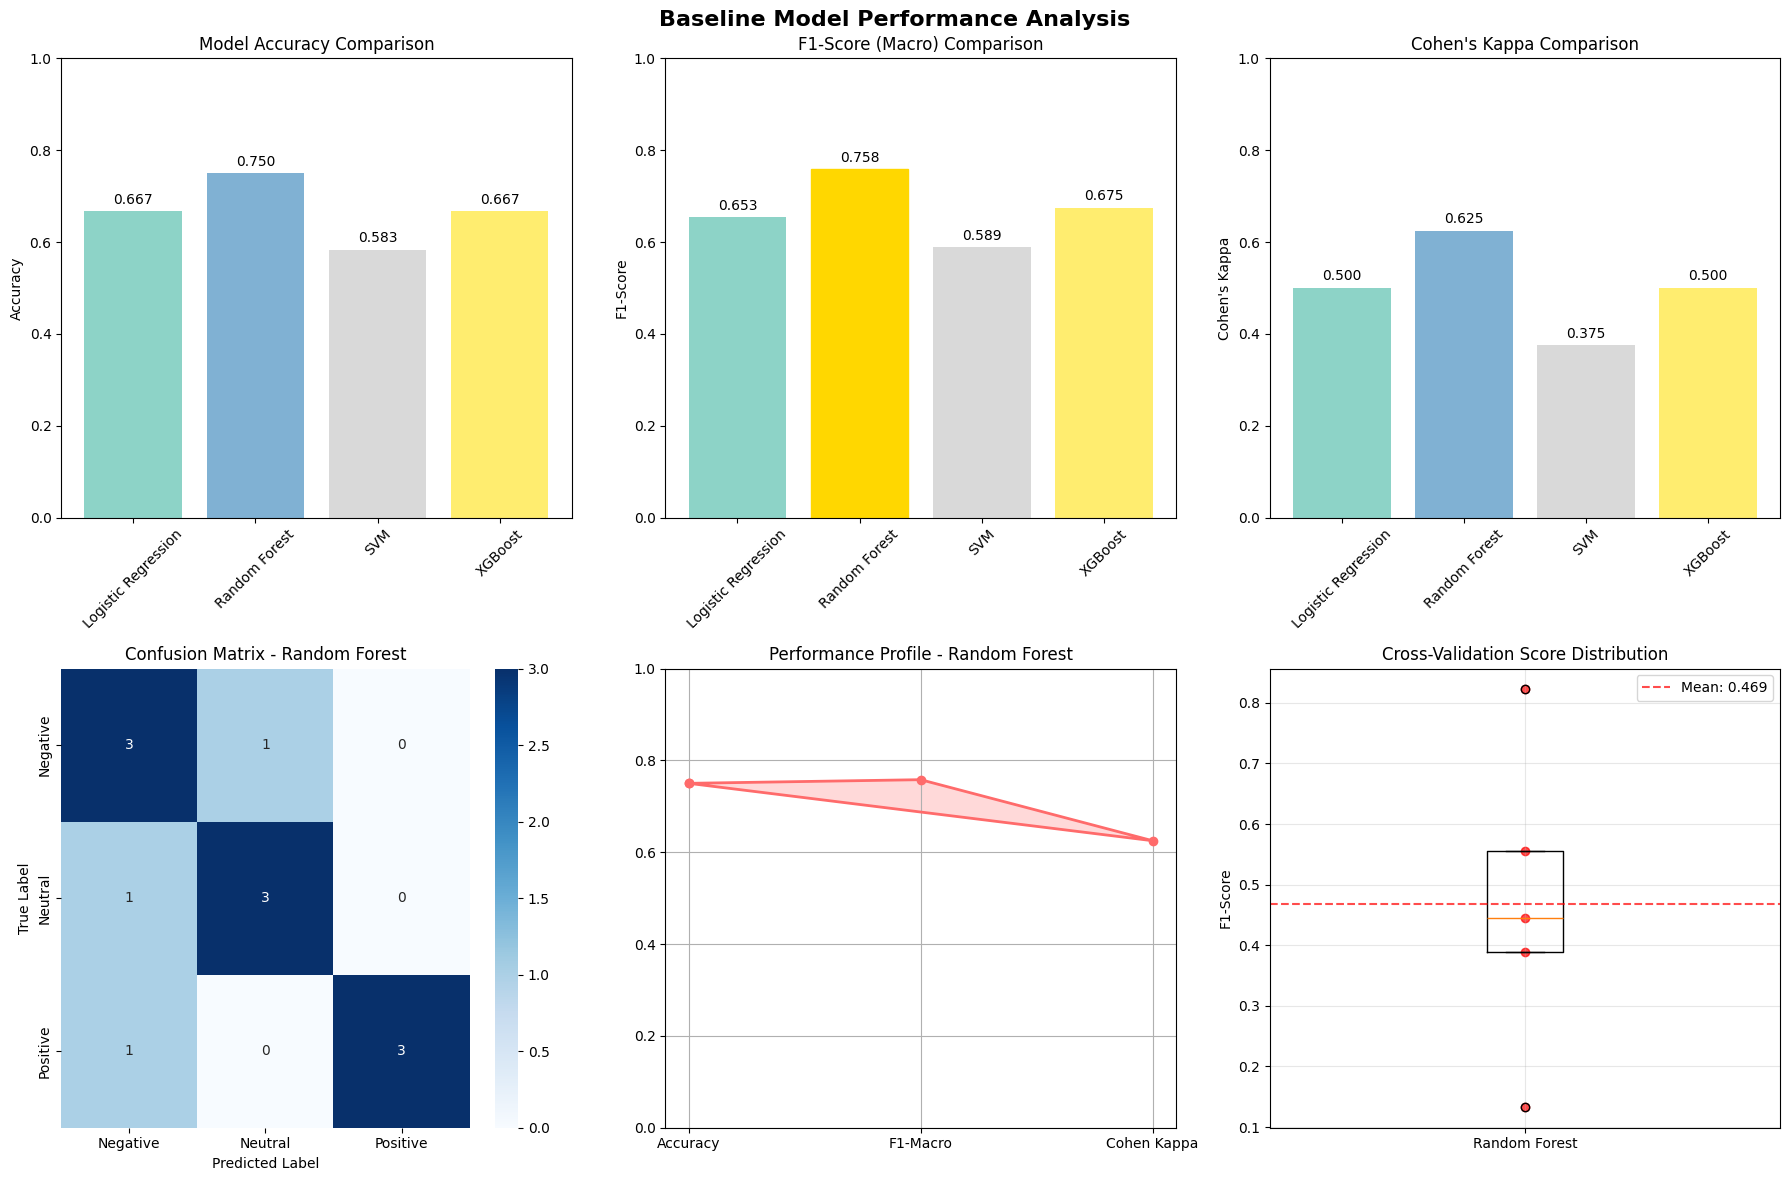

📊 Model Performance Dashboard created!
🏆 Best Model: Random Forest
📈 Key Insights:
   • Best F1-Score: 0.7579
   • Cross-validation stability: 0.2245 std deviation
   • Model ranking by F1-score: ['Random Forest', 'XGBoost', 'Logistic Regression', 'SVM']


In [10]:
# 1. Model Performance Comparison Dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Baseline Model Performance Analysis', fontsize=16, fontweight='bold')

# 1.1 Model Accuracy Comparison
model_names = list(results_df.index)
accuracies = results_df['accuracy'].values
colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))

bars = axes[0,0].bar(model_names, accuracies, color=colors)
axes[0,0].set_title('Model Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_ylim(0, 1)
axes[0,0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{acc:.3f}', ha='center', va='bottom')

# 1.2 F1-Score Comparison
f1_scores = results_df['f1_macro'].values
bars = axes[0,1].bar(model_names, f1_scores, color=colors)
axes[0,1].set_title('F1-Score (Macro) Comparison')
axes[0,1].set_ylabel('F1-Score')
axes[0,1].set_ylim(0, 1)
axes[0,1].tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, f1 in zip(bars, f1_scores):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{f1:.3f}', ha='center', va='bottom')

# Highlight best model
best_idx = np.argmax(f1_scores)
bars[best_idx].set_color('#FFD700')  # Gold color for best model

# 1.3 Cohen's Kappa Comparison
kappa_scores = results_df['cohen_kappa'].values
bars = axes[0,2].bar(model_names, kappa_scores, color=colors)
axes[0,2].set_title("Cohen's Kappa Comparison")
axes[0,2].set_ylabel("Cohen's Kappa")
axes[0,2].set_ylim(0, 1)
axes[0,2].tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, kappa in zip(bars, kappa_scores):
    axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{kappa:.3f}', ha='center', va='bottom')

# 1.4 Confusion Matrix for Best Model
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0],
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
axes[1,0].set_title(f'Confusion Matrix - {best_model_idx}')
axes[1,0].set_xlabel('Predicted Label')
axes[1,0].set_ylabel('True Label')

# 1.5 Performance Metrics Radar Chart
metrics = ['Accuracy', 'F1-Macro', 'Cohen Kappa']
best_metrics = [results_df.loc[best_model_idx, 'accuracy'],
                results_df.loc[best_model_idx, 'f1_macro'], 
                results_df.loc[best_model_idx, 'cohen_kappa']]

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
best_metrics += best_metrics[:1]  # Complete the circle
angles += angles[:1]

axes[1,1].plot(angles, best_metrics, 'o-', linewidth=2, label=best_model_idx, color='#FF6B6B')
axes[1,1].fill(angles, best_metrics, alpha=0.25, color='#FF6B6B')
axes[1,1].set_xticks(angles[:-1])
axes[1,1].set_xticklabels(metrics)
axes[1,1].set_ylim(0, 1)
axes[1,1].set_title(f'Performance Profile - {best_model_idx}')
axes[1,1].grid(True)

# 1.6 Cross-Validation Score Distribution
axes[1,2].boxplot(cv_scores, labels=[best_model_idx])
axes[1,2].scatter([1] * len(cv_scores), cv_scores, color='red', alpha=0.7)
axes[1,2].set_title(f'Cross-Validation Score Distribution')
axes[1,2].set_ylabel('F1-Score')
axes[1,2].grid(True, alpha=0.3)

# Add mean line
mean_cv = cv_scores.mean()
axes[1,2].axhline(mean_cv, color='red', linestyle='--', alpha=0.7, 
                  label=f'Mean: {mean_cv:.3f}')
axes[1,2].legend()

plt.tight_layout()
plt.show()

print("📊 Model Performance Dashboard created!")
print(f"🏆 Best Model: {best_model_idx}")
print(f"📈 Key Insights:")
print(f"   • Best F1-Score: {best_score:.4f}")
print(f"   • Cross-validation stability: {cv_scores.std():.4f} std deviation")
print(f"   • Model ranking by F1-score: {results_df.sort_values('f1_macro', ascending=False).index.tolist()}")